In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skdat
from ipywidgets import interact

# Generate fake data

Text(0.5, 1.0, 'Red signal')

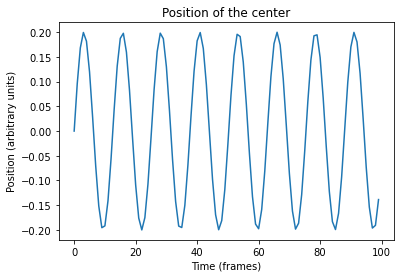

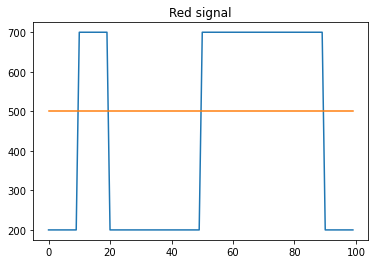

In [29]:
%matplotlib inline
img_box = (-1, 1)

num_frames = 100
tspan = np.arange(num_frames)
signal_level = 500
noise_level = 1000

opt = {
    'centers': [[0.0, 0.0]],
    'cluster_std': 0.2,
    'n_features': 2 # Dimension
}

center_time_series = np.array([0.2*np.sin(tspan/2), np.zeros(num_frames)])

plt.plot(center_time_series[0,:])
plt.title("Position of the center")
plt.ylabel("Position (arbitrary units)")
plt.xlabel("Time (frames)")

opt['center_box'] = (img_box[0]+2*opt['cluster_std'], img_box[1]-2*opt['cluster_std'])

signal_baseline = 200
amp_true = signal_baseline * np.ones(num_frames)
amp_true[10:20] += signal_level
amp_true[50:90] += signal_level
amp_true = [int(a) for a in amp_true]

amp_red = signal_level * np.ones(num_frames)
amp_red = [int(a) for a in amp_red]

plt.figure()
plt.plot(amp_true)
plt.title("True signal")

plt.plot(amp_red)
plt.title("Red signal")

In [3]:
all_dat = []
all_red = []
all_noise = []
all_noise2 = []

for i in range(num_frames):
    opt['centers'] = [center_time_series[:,i]]
    dat, _ = skdat.make_blobs(n_samples=amp_true[i], **opt)
    all_dat.append(dat)
    dat_red, _ = skdat.make_blobs(n_samples=amp_red[i], **opt)
    all_red.append(dat_red)
    noise = 2*(-0.5 + np.random.rand(noise_level, 2))
    all_noise.append(noise)
    noise2 = 2*(-0.5 + np.random.rand(noise_level, 2))
    all_noise2.append(noise2)

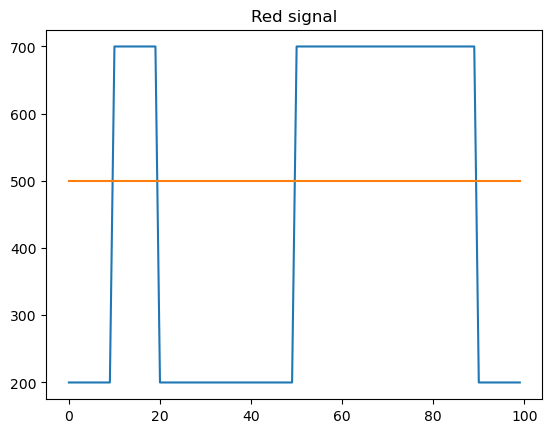

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(i)>

In [4]:
def f(i):
    plt.scatter(all_noise[i][:,0], all_noise[i][:,1], label='noise')
    plt.scatter(all_dat[i][:,0], all_dat[i][:,1], label='signal')
    plt.legend()
    plt.title('Real signal')

interact(f, i=(0,num_frames))

# Build histogram (i.e. image)

In [5]:
noisy_dat = [np.vstack([n, d]) for n, d in zip(all_noise, all_dat)]
noisy_dat_red = [np.vstack([n, d]) for n, d in zip(all_noise2, all_red)]
noise_only = [np.vstack([n]) for n in all_noise]

In [6]:
pixel_sz = 0.1
bins = int(np.ceil(2.0 / pixel_sz))

vid_only_noise = np.zeros((num_frames, bins, bins))
vid_noisy = np.zeros((num_frames, bins, bins))
vid_clean = np.zeros((num_frames, bins, bins))
vid_red_noisy = np.zeros((num_frames, bins, bins))
vid_red_clean = np.zeros((num_frames, bins, bins))

for i, (noisy_dat, dat, dat_red, noisy_red, n_only) in enumerate(zip(noisy_dat, all_dat, all_red, noisy_dat_red, noise_only)):
    vid_only_noise[i,...] = np.histogram2d(n_only[:,0], n_only[:,1], bins=bins)[0]
    
    vid_noisy[i,...] = np.histogram2d(noisy_dat[:,0], noisy_dat[:,1], bins=bins)[0]
    vid_clean[i,...] = np.histogram2d(dat[:,0], dat[:,1], bins=bins)[0]
    
    vid_red_noisy[i,...] = np.histogram2d(noisy_red[:,0], noisy_red[:,1], bins=bins)[0]
    vid_red_clean[i,...] = np.histogram2d(dat_red[:,0], dat_red[:,1], bins=bins)[0]

In [7]:
def f(i):
#     plt.imshow(vid_clean[i])
    plt.subplot(121)
    plt.imshow(vid_noisy[i])
    plt.title("Green channel")
    plt.subplot(122)
    plt.imshow(vid_red_noisy[i])
    plt.title("Red channel")

interact(f, i=(0,num_frames))

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(i)>

# Simple filtering in image space

In [8]:
from skimage.filters import gaussian

In [9]:

for i, _ in enumerate(all_dat):
    vid_noisy[i,...] = gaussian(vid_noisy[i,...])
    vid_clean[i,...] = gaussian(vid_clean[i,...])
    
    vid_red_noisy[i,...] = gaussian(vid_red_noisy[i,...])
    vid_red_clean[i,...] = gaussian(vid_red_clean[i,...])

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(i)>

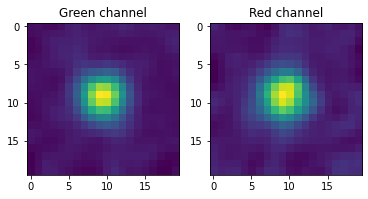

In [10]:
%matplotlib inline
def f(i):
#     plt.imshow(vid_clean[i])
    plt.subplot(121)
    plt.imshow(vid_noisy[i])
    plt.title("Green channel")
    plt.subplot(122)
    plt.imshow(vid_red_noisy[i])
    plt.title("Red channel")

interact(f, i=(0,num_frames))

# Draw a mask by hand

In [11]:
import napari

In [12]:
vid_clean[0,...].shape

(20, 20)

In [13]:
viewer = napari.view_image(vid_noisy)
# labels_layer = viewer.add_(np.zeros_like(img), name='segmentation')

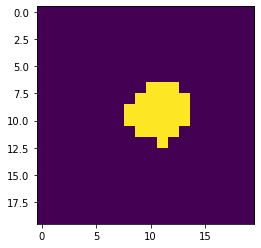

In [15]:
############# DRAW BY HAND
mask_layer = viewer.layers['Shapes']
masks = mask_layer.to_labels(vid_clean[0].shape)
# masks
plt.imshow(masks)

# Calculate traces in various ways

In [16]:
# amp_true = opt['n_samples']
# noise_true = np.sqrt(opt['n_samples']) # Shot noise

# print(f"Given shot noise, best we can do is {amp_true} +- {noise_true}")

### First: just ROI

In [17]:
all_labels = np.unique(masks)[1:] # Remove 0=background
all_labels

array([1])

In [18]:
amp_roi_clean = {}
amp_roi_noisy = {}
red_roi_clean = {}
red_roi_noisy = {}

def get_amps_roi(mask, vid, back_per_pix=0):
    background = back_per_pix*np.count_nonzero(mask)
    return np.array([np.sum(img[mask])-background for img in vid])

background_per_pixel = np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))
print(f"Estimated background per pixel to be: {background_per_pixel}")

for label in all_labels:
    this_mask = masks==label
    
    amp_roi_clean[label] = get_amps_roi(this_mask, vid_clean)
    amp_roi_noisy[label] = get_amps_roi(this_mask, vid_noisy, background_per_pixel)
    
    red_roi_clean[label] = get_amps_roi(this_mask, vid_red_clean)
    red_roi_noisy[label] = get_amps_roi(this_mask, vid_red_noisy, background_per_pixel)


Estimated background per pixel to be: 3.180914215574749


Text(0.5, 1.0, 'Ratio')

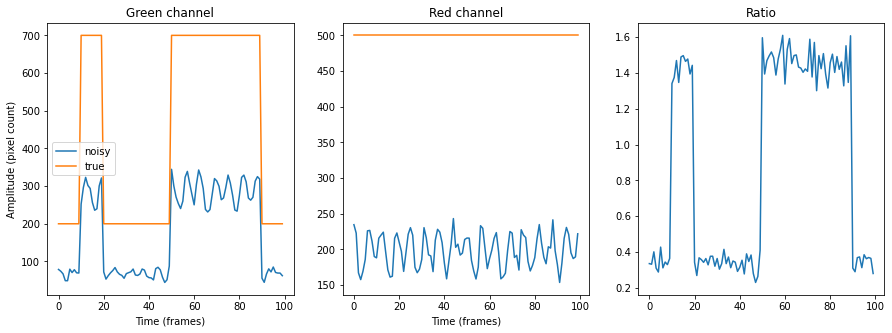

In [32]:
%matplotlib inline
plt.figure(figsize=(15,5))

to_plot_clean = False

plt.subplot(131)
if to_plot_clean:
    plt.plot(amp_roi_clean[1], label="clean")
plt.plot(amp_roi_noisy[1], label="noisy")
plt.plot(amp_true, label="true")
plt.ylabel("Amplitude (pixel count)")
plt.xlabel("Time (frames)")
plt.legend()
plt.title("Green channel")

plt.subplot(132)
if to_plot_clean:
    plt.plot(red_roi_clean[1], label="clean")
plt.plot(red_roi_noisy[1], label="noisy")
plt.plot(amp_red, label="true")
plt.title("Red channel")
plt.xlabel("Time (frames)")
# plt.legend()


plt.subplot(133)
if to_plot_clean:
    plt.plot(amp_roi_clean[1] / red_roi_clean[1], label="clean")
plt.plot(amp_roi_noisy[1] / red_roi_noisy[1], label="noisy")
# plt.legend()
plt.title("Ratio")


### Second: ROI with top percentile

In [20]:
all_labels = np.unique(masks)[1:] # Remove 0=background
all_labels

array([1])

In [21]:
amp_quantile_clean = {}
amp_quantile_noisy = {}

quantile = 0.5

def get_amps_quantile(mask, vid, quantile, back_per_pix=0):
    trace = []
    for img in vid:
        vals = img[mask]
        thresh = np.quantile(vals, quantile)
        submask = vals>thresh
        
        background = back_per_pix*np.count_nonzero(submask)
        trace.append(np.sum(vals[submask]) - background)
    return np.array(trace)

background_per_pixel = np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))

background_per_pixel = 0
print(f"Estimated background per pixel to be: {background_per_pixel}")

for label in all_labels:
    this_mask = masks==label
    
    amp_quantile_clean[label] = get_amps_quantile(this_mask, vid_clean, quantile)
    amp_quantile_noisy[label] = get_amps_quantile(this_mask, vid_clean, quantile, background_per_pixel)


Estimated background per pixel to be: 0


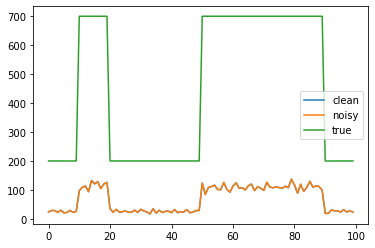

In [22]:
plt.plot(amp_quantile_clean[1], label="clean")
plt.plot(amp_quantile_noisy[1], label="noisy")
plt.plot(amp_true, label="true")
plt.legend()

### Third: Fit the histogram

In [77]:
from scipy.optimize import curve_fit

In [183]:
amp_hist_clean = {}
amp_hist_noisy = {}

def to_fit(x, sigma):
    # Maxwell-boltzmann in 3d, Rayleigh in 2d
    s2 = sigma**2.0
    return (x/s2) * np.exp(-x**2/s2)

# edges = np.arange(0, max(vals)+pixel_sz, pixel_sz)
edges = np.arange(np.max(vid_noisy[10])+1)

def get_amps_hist(mask, vid, back_per_pix=0):
    trace = []
    for img in vid:
        vals = np.ravel(img[mask])
        subtracted_vals = np.clip(vals - back_per_pix, 0, 1000)
        hist_dat, _ = np.histogram(subtracted_vals[subtracted_vals>0], bins=edges)
        popt, _ = curve_fit(to_fit, edges[:-1], hist_dat)
        trace.append(popt[0]*np.sum(subtracted_vals))
        
    return np.array(trace)

background_per_pixel = np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))
print(f"Estimated background per pixel to be: {background_per_pixel}")

for label in all_labels:
    this_mask = masks==label
    
    amp_hist_clean[label] = get_amps_hist(this_mask, vid_clean)
    amp_hist_noisy[label] = get_amps_hist(this_mask, vid_noisy, background_per_pixel)


Estimated background per pixel to be: 2.5295999504086075


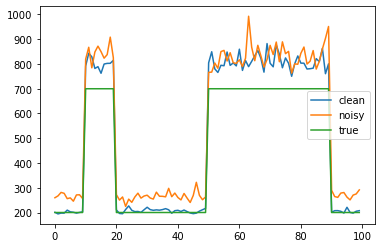

In [184]:
plt.plot(amp_hist_clean[1], label="clean")
plt.plot(amp_hist_noisy[1], label="noisy")
plt.plot(amp_true, label="true")
plt.legend()

In [200]:
this_mask = masks==1
# vals = np.ravel(np.clip(vid_noisy[10][this_mask], 0, 100))
vals = np.ravel(np.clip(vid_noisy[10][this_mask]-background_per_pixel, 0, 100))
# vals = np.ravel(np.clip(vid_clean[10][this_mask], 0, 100))

vals = vals[vals>0]

# edges = np.arange(0, max(vals)+pixel_sz, pixel_sz)
edges = np.arange(0, max(vals)+1, 0.1)
hist_dat, _ = np.histogram(vals, bins=edges, density=True)

popt, _ = curve_fit(to_fit, edges[:-1], hist_dat)#, p0=(100, pixel_sz))

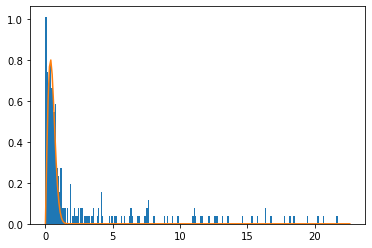

In [201]:
# plt.plot(hist_dat, 'o')
plt.hist(vals, bins=edges, density=True)
plt.plot(edges, to_fit(edges, *popt))

In [204]:
popt[0]*np.sum(vals)

386.9682464582072

In [99]:
from scipy.special import factorial

def to_fit_only_noise(k, lam):
    # Add poisson distribution for remaining noise
    return (lam**k) * np.exp(-lam) / factorial(k)

this_mask = masks==1
# vals = np.ravel(np.clip(vid_noisy[10][this_mask]-background_per_pixel, 0, 100))
vals = np.ravel(np.clip(vid_only_noise[10][this_mask], 0, 100))

# edges = np.arange(0, max(vals)+pixel_sz, pixel_sz)
edges = np.arange(min(vals), max(vals)+1)
hist_dat, _ = np.histogram(vals, bins=edges, density=True)

popt, _ = curve_fit(to_fit_only_noise, edges[:-1], hist_dat)

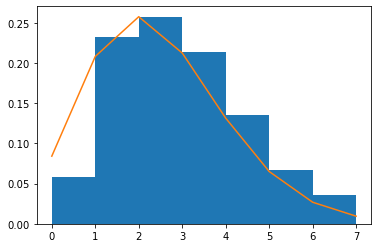

In [102]:

plt.hist(vals, bins=edges, density=True)
plt.plot(edges, to_fit_only_noise(edges, *popt))

In [101]:
popt

array([2.4743214])

# Fourth: fit a histogram including noise

Estimated background per pixel to be: 3.794399925612911
9356.92132510607


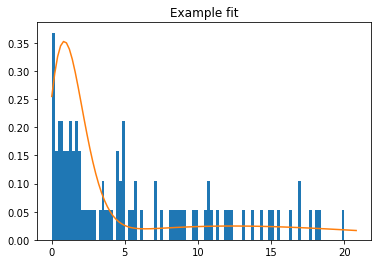

In [206]:
def to_fit_including_noise(x, sigma1, lam):
    # Two distributions, one for background
    s1 = sigma1**2.0
    noise_distribution = (lam**x) * np.exp(-lam) / factorial(x)
    signal_distribution = (x/s1) * np.exp(-x**2/s1)
    return noise_distribution + signal_distribution


background_per_pixel = 1.5*np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))
print(f"Estimated background per pixel to be: {background_per_pixel}")
this_mask = masks==1
vals = np.ravel(np.clip(vid_noisy[15][this_mask]-background_per_pixel, 0, 100))
vals = vals[vals>0]

# edges = np.arange(0, max(vals)+pixel_sz, pixel_sz)
edges = np.arange(min(vals), max(vals)+1, 0.2)
hist_dat, _ = np.histogram(vals, bins=edges, density=True)

popt, _ = curve_fit(to_fit_including_noise, edges[:-1], hist_dat, p0=[100,background_per_pixel], bounds=[[0,0], [1000,10]])

plt.hist(vals, bins=edges, density=True)
plt.plot(edges, to_fit_including_noise(edges, *popt))
plt.title('Example fit')
print(popt[0]*np.sum(vals))

In [216]:
amp_hist_clean = {}
amp_hist_noisy = {}

# edges = np.arange(0, max(vals)+pixel_sz, pixel_sz)
edges = np.arange(0, np.max(vid_noisy[10])+1, 0.2)

def get_amps_hist(mask, vid, p0):
    trace = []
    for img in vid:
        try:
            vals = np.ravel(img[mask])
            hist_dat, _ = np.histogram(vals, bins=edges)
            popt, _ = curve_fit(to_fit_including_noise, edges[:-1], hist_dat, bounds=[[0,0], [1000,10]])
#             trace.append(popt[0]*np.sum(vals))
            trace.append(popt[0])
        except RuntimeError:
            trace.append(np.nan)
        
    return np.array(trace)

background_per_pixel = np.mean(get_amps_roi(masks==0, vid_noisy)/np.count_nonzero(masks==0))
print(f"Estimated background per pixel to be: {background_per_pixel}")

# Initial conditions
p0 = [100,background_per_pixel]

for label in all_labels:
    this_mask = masks==label
    
    amp_hist_clean[label] = get_amps_hist(this_mask, vid_clean, [100,0])
    amp_hist_noisy[label] = get_amps_hist(this_mask, vid_noisy, [100,3])


Estimated background per pixel to be: 2.5295999504086075


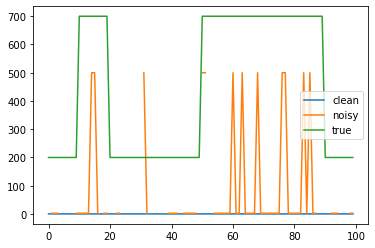

In [217]:
plt.plot(amp_hist_clean[1], label="clean")
plt.plot(amp_hist_noisy[1], label="noisy")
plt.plot(amp_true, label="true")
plt.legend()